# Examples for paper "A Quantum Kalman Filter-Based PID Controller"

https://arxiv.org/abs/1701.06578 (John Gough)

Thien Nguyen

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from qutip.cy.spmatfuncs import (cy_expect_rho_vec, spmv)
import numpy as np
import math
from qutip import *

# Proportional Control

In Schrodinger's picture, we can write the stochastic master equation in the following form (Wiseman & Milburn):

$$ d\rho_c(t) = -i[H + H_{fb}(t), \rho_c(t)] dt + \mathcal{D}[B] \rho_c(t) dt + \mathcal{D}[A]\rho_c(t) dt + \sqrt{\eta}\mathcal{H}[A]\rho_c(t) dW,$$

where $A$ are dissipation operators that are monitored.

This equation can be implemented by $D_1$ and $D_2$ callback functions in stochastic master equation.

In proportional control scheme, the feedback Hamiltonian has the form of:
$$H_{fb}(t) = i\kappa_P(r(t) - \hat{a}(t))a^\dagger - i \kappa_P^*(r(t) - \hat{a}(t))^*a $$

Actually, in simulation environment (discrete time), this is implemented by:

$$H_{fb}(k+1) = i\kappa_P(r(k+1) - \hat{a}(k))a^\dagger - i \kappa_P^*(r(k+1) - \hat{a}(k))^*a,$$

where $k$ is the index in the time sequence, and $\hat{a}(k) = $ Trace$[\rho_c(k)a]$


In [37]:
# Parameters
# Coupling strength of the cavity
gamma = 1.0

# Proportional feedback strength
kappa_P = 0.5

# Cavity oscillation freq. (assume in rotating frame)
omega = 0.0

# Simulation time
tlist = np.linspace(0,5.0,5001)

# number of levels for the cavity
Nlevel = 20 

# Cavity operator
a = destroy(Nlevel)

# Cavity Hamiltonian
H = omega*a.dag()*a

# Dissipation operator of the cavity    
L = np.sqrt(gamma)*a

# No deterministic dissipation channel 
c_ops = []

# Stochastic (monitored channel)
sc_ops = [L]

# intial state: coherent state
psi0 = coherent(Nlevel, 1.0 + 1j*1.0)  

# target state: assume a coherent state
# Stationary target, we can consider time-dependent target as well
psi_target = coherent(Nlevel, 0.25j)
# Reference signal (stationary)
# r = Trace[\rho_target a]
r = expect(a, psi_target)

# (A) superoperator definition 
#     A[0] = spre(a) = A_L : Multiply on the left
#     A[1] = spost(a) = A_R : Multiply on the right
#     A[2] = spre(a.dag()) = Ad_L : Adjoint and Multiply on the left
#     A[3] = spost(a.dag()) = Ad_R: Adjoint and Multiply on the right
#     A[4] = spre(a.dag() * a) = (Ad A)_L: Multiply on the left by L^\dagger L
#     A[5] = spost(a.dag() * a) = (Ad A)_R: Multiply on the right by L^\dagger L
#     A[6] = (spre(a) * spost(a.dag()) = A_L * Ad_R: Multiply on the left by L and multiply on the right by L^\dagger
#     A[7] = lindblad_dissipator(a): Full Lindblad operator: L * rho * L.dag() - 0.5 * L.dag()*L*rho - 0.5 * rho * L.dag()*L

 
# D1 and D2 definitions for stochastic homodyne detection
# D1: Deterministic part with feedback Hamiltonian
def d1_rho_func(t, rho_vec, A, args): 
    aHat = cy_expect_rho_vec(spre(a).data, rho_vec, 1)
    Hfb = 1j*kappa_P*(r - aHat)*a.dag() - 1j*np.conjugate(kappa_P*(r - aHat))*a
    # normal dynamics     
    op_t = A[7]
    # Feedback
    op_t +=  liouvillian(Hfb, []).data   
    return spmv(op_t, rho_vec)

# D2: Stochastic part
def d2_rho_func(t, rho_vec, A, args):
    n_sum = A[0] + A[3]
    e1 = cy_expect_rho_vec(n_sum, rho_vec, False)
    return [n_sum * rho_vec - e1 * rho_vec]

# expected operators: quadrature and number opererators
e_ops = [0.5*(a+a.dag()), 0.5*1j*(a.dag() - a), a*a.dag()]
m_ops = [[L + L.dag()]]
ntraj = 1 
nsubsteps = 100


#fresh run, new noise generated
result = smesolve(H, psi0, tlist, c_ops, sc_ops, e_ops, ntraj=ntraj, nsubsteps=nsubsteps, d1=d1_rho_func,
                  d2=d2_rho_func, distribution='normal', m_ops=m_ops, dW_factors=[np.sqrt(1/gamma)],
                  store_measurement=True)

Total run time: 470.57s


## Plot: Quadrature, photon number

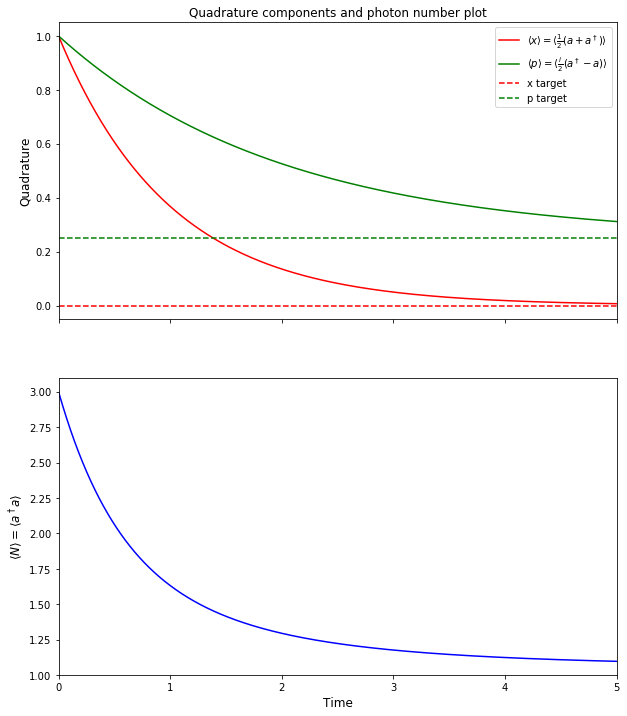

In [38]:
#Plotting the results 
fig, (axes1, axes2) = plt.subplots(2,1, figsize=(10,12), sharex=True)
# Plot 1: Quadrature
x = result.expect[0]
p = result.expect[1]
axes1.plot(tlist, x,'r',label=r'$\langle x \rangle = \langle \frac{1}{2}(a + a^\dagger) \rangle$')
axes1.plot(tlist, p,'g',label=r'$\langle p \rangle = \langle \frac{i}{2}(a^\dagger - a) \rangle$')
xBar = expect(0.5*(a+a.dag()), psi_target)
pBar = expect(0.5*1j*(a.dag() - a), psi_target)
axes1.plot((tlist[0], tlist[tlist.size - 1]), (xBar, xBar), 'r--', label= "x target")
axes1.plot((tlist[0], tlist[tlist.size - 1]), (pBar, pBar), 'g--', label= "p target")
axes1.legend(loc=0)
axes1.set_xlim([tlist[0], tlist[tlist.size - 1]])
axes1.set_ylabel('Quadrature', fontsize=12)
axes1.set_title('Quadrature components and photon number plot', fontsize=12)

# Plot 2: photon number
nbPhoton = result.expect[2]
axes2.plot(tlist, nbPhoton, 'b')
axes2.set_xlim([tlist[0], tlist[tlist.size - 1]])
axes2.set_xlabel('Time', fontsize=12)
axes2.set_ylabel(r'$\langle N \rangle = \langle a^\dagger a \rangle$', fontsize=12)


### Remark: For Proportional control, a large steady-state error exists!
 

### PI Control

In PI control scheme, the feedback Hamiltonian has the form of:

$$H_{fb}(t) = H_P(t) + H_I(t),$$

in which $H_P(t)$ is similar to the P controller and $H_I(t)$ is computed by:

$$H_I(t) = i\kappa_I\left[\int_0^t(r(\tau) - \hat{a}(\tau))d\tau \right]a^\dagger + H.c.$$

In [39]:
# Parameters
# Coupling strength of the cavity
gamma = 1.0

# Proportional feedback strength
kappa_P = 0.5

# Integral feedback strength
kappa_I = 0.1

# Cavity oscillation freq. (assume in rotating frame)
omega = 0.0

# Simulation time
nsteps = 5001
nsubsteps = 100
tfinal = 5.0
dt = tfinal/(nsteps*nsubsteps)
tlist = np.linspace(0, tfinal, nsteps)

# number of levels for the cavity
Nlevel = 20 

# Cavity operator
a = destroy(Nlevel)

# Cavity Hamiltonian
H = omega*a.dag()*a

# Dissipation operator of the cavity    
L = np.sqrt(gamma)*a

# No deterministic dissipation channel 
c_ops = []

# Stochastic (monitored channel)
sc_ops = [L]

# intial state: coherent state
psi0 = coherent(Nlevel, 1.0 + 1j*1.0)     

# target state: assume a coherent state
# Stationary target, we can consider time-dependent target as well
psi_target = coherent(Nlevel, 0.25j)
# Reference signal (stationary)
# r = Trace[\rho_target a]
r = expect(a, psi_target)

# Array to store the error signal
e_array = []
# D1 and D2 definitions for stochastic homodyne detection
# D1: Deterministic part with feedback Hamiltonian
def d1_rho_func(t, rho_vec, A, args): 
    aHat = cy_expect_rho_vec(spre(a).data, rho_vec, 1)
    #e_cummulative = e_cummulative + (r - aHat)*dt;
    e_array.append((r - aHat)*dt)
    e_cummulative = sum(e_array)
    Hp = 1j*kappa_P*(r - aHat)*a.dag() - 1j*np.conjugate(kappa_P*(r - aHat))*a
    Hi = 1j*kappa_I*e_cummulative*a.dag() - 1j*np.conjugate(kappa_I*e_cummulative)*a
    Hfb = Hp + Hi
    # normal dynamics     
    op_t = A[7]
    # Feedback
    op_t +=  liouvillian(Hfb, []).data   
    return spmv(op_t, rho_vec)

# D2: Stochastic part
def d2_rho_func(t, rho_vec, A, args):
    n_sum = A[0] + A[3]
    e1 = cy_expect_rho_vec(n_sum, rho_vec, False)
    return [n_sum * rho_vec - e1 * rho_vec]

# expected operators: quadrature and number opererators
e_ops = [0.5*(a+a.dag()), 0.5*1j*(a.dag() - a), a*a.dag()]
m_ops = [[L + L.dag()]]
ntraj = 1 



#fresh run, new noise generated
result_PI = smesolve(H, psi0, tlist, c_ops, sc_ops, e_ops, ntraj=ntraj, nsubsteps=nsubsteps, d1=d1_rho_func,
                  d2=d2_rho_func, distribution='normal', m_ops=m_ops, dW_factors=[np.sqrt(1/gamma)],
                  store_measurement=True)

Total run time: 3688.19s


# Plot: Quadrature, photon number

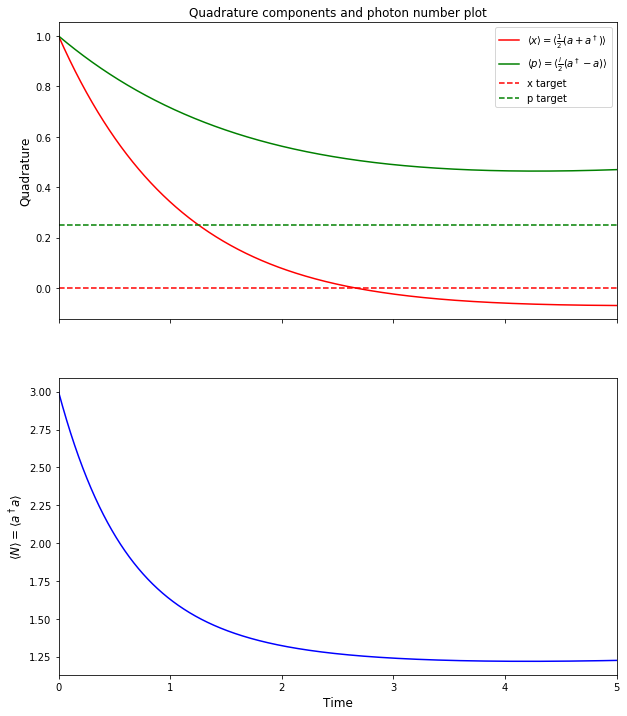

In [40]:
#Plotting the results 
fig, (axes1, axes2) = plt.subplots(2,1, figsize=(10,12), sharex=True)
# Plot 1: Quadrature
x = result_PI.expect[0]
p = result_PI.expect[1]
axes1.plot(tlist, x,'r',label=r'$\langle x \rangle = \langle \frac{1}{2}(a + a^\dagger) \rangle$')
axes1.plot(tlist, p,'g',label=r'$\langle p \rangle = \langle \frac{i}{2}(a^\dagger - a) \rangle$')
xBar = expect(0.5*(a+a.dag()), psi_target)
pBar = expect(0.5*1j*(a.dag() - a), psi_target)
axes1.plot((tlist[0], tlist[tlist.size - 1]), (xBar, xBar), 'r--', label= "x target")
axes1.plot((tlist[0], tlist[tlist.size - 1]), (pBar, pBar), 'g--', label= "p target")
axes1.legend(loc=0)
axes1.set_xlim([tlist[0], tlist[tlist.size - 1]])
axes1.set_ylabel('Quadrature', fontsize=12)
axes1.set_title('Quadrature components and photon number plot', fontsize=12)

# Plot 2: photon number
nbPhoton = result_PI.expect[2]
axes2.plot(tlist, nbPhoton, 'b')
axes2.set_xlim([tlist[0], tlist[tlist.size - 1]])
axes2.set_xlabel('Time', fontsize=12)
axes2.set_ylabel(r'$\langle N \rangle = \langle a^\dagger a \rangle$', fontsize=12)